<h2>Spaceship Titanic ML solution</h2>

The purpose of this notebook is to describe the process by which we will predict whether a Spaceship Titanic passenger was transported to an alternate dimension during its collision with the spacetime anomaly. The process followed will be a typical data science workflow, and will include data exploration, wrangling, and prediction making, amongst other steps.

<h3>Problem Description</h3>

The problem has been defined by Kaggle as: 
    <ul><li>In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.</li></ul>

In addition, there is some notable domain information, also described on Kaggle. Here are some key points:
<ul>
    <li>The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board</li>
    <li>Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!</li>

<ul>

In [867]:
#data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#prediction
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

import tensorflow as tf
from keras.api.models import Sequential
from keras.api.layers import Dense, Dropout


from sklearn.preprocessing import StandardScaler


<h3>Loading in data</h3>

Using the pandas package, we begin by loading the data into data frames. In addition, we combine data sets to allow us to run operations on both datasets simultaneously.


In [868]:
train_df = pd.read_csv('./train (1).csv')
test_df = pd.read_csv('./test (1).csv')
combine = [train_df, test_df]

<h3>Understanding the data</h3>

The first step to solving the problem is understanding the data. In order for us to understand the data, we display the data and make some observations. 

In [869]:
print(train_df.columns.values)

['PassengerId' 'HomePlanet' 'CryoSleep' 'Cabin' 'Destination' 'Age' 'VIP'
 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck' 'Name'
 'Transported']


The above python code gives us an idea of what data we are working with. However, we will want to be certain about the actual structure of the data in order to make observations which will help us in solving the problem. First, let us take a look at what the data physically looks like.

In [870]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


<h3>Observations</h3>

Based on the above results, we can classify the features according to the statistical types of the data:


<b>Nominal:</b>
PassengerId, HomePlanet, CryoSleep, Destination, VIP, Name, Transported

<b>Continuous:</b>
Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

<b>Mixed:</b>
Cabin

Note that Cabin has been marked as "Mixed" since it contains a mix of data types describing the location of the cabin.

<h4>Now that we have a better understanding of what we are working with, we will further explore our data</h4>

In [871]:
train_df.info()
print('*' * 60)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data co

<h4>Nulls</h4>
As seen above, both datasets contain a significant number of null, blank, or empty values. The only columns that do not contain null values are:

<b>Training set:</b>
PassengerId, Transported<br>
<b>Testing set:</b>
PassengerId

This means that all other columns require correcting in terms of null-handling.


<h3>Distribution of numerical features</h3>

For further understanding of out data, we will explore how the numerical features in our training set are distributed.

In [872]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


<h3>Observations for Numerical features</h3>

<ul>
<li>Miniscule number of elderly passengers. (<5%)</li>
<li>Highest average spend for passengers was in the Food Court, which implies a greater amount of time spent here than other recreatinal areas.</li>
<li>Room service contains both lowest average and max spend, implying passengers would rather eat at the food court than order room service.</li>
</ul>

<h3>Distribution of Non-numeric features</h3>

For further understanding of out data, we will explore how the non-numeric features in our training set are distributed.

In [873]:
train_df.describe(include=['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


<h3>Observations for non-numeric data</h3>

<ul>
<li>HomePlanet has three possible values, with Earth being the most frequent.</li>
<li>CryoSleep has two possible values, true or false, with false being the most frequent.</li>
<li>Cabin has a high ratio of duplicate values (~23%).</li>
<li>Cabin G/734/S was shared by eight people.</li>
<li>Destination has three possible values, with the majority being TRAPPIST-1e.</li>
<li>VIP has two possible values, true or false, with false being the vast majority (~98%).</li>
<li>There are twenty names which are duplicated. Further exploration needed to determine the cause.</li>
</ul>

<h3>Assumptions</h3>

Based on the analysis conducted up until this point, the following assumptions can be made:

<b>Completing:</b>
<ul><li>We want to complete all features which currently contain null values, aside from the recreational spend features. This is because no data in this case is meaningful as it is indicative of a trend, and not there being random absence of data. </li></ul>

<b>Correcting:</b>
<ul>
<li>PassengerId may be dropped, as it does not have an affect on being transported.</li>
<li>Name may not have an impact on being transported, and contains duplicates. May be dropped from analysis.</li>
<li>HomePlanet may not have an impact on being transported and thus may be dropped from our analysis.</li></ul>

<b>Creating</b>
<ul>
<li>Cabin may be separated into multiple features and one-hot encoded, as it is likely that the deck, or at least side have an impact on being transported.</li>
<li>We may want to create a new feature for Age bands to turn this into an ordinal categorical feature.</li>
<li>We may want to create a feature indicating where the passenger spent the most money. Alternatively, this can be handled similarly to Age depending on what helps our analysis more.</li>
</ul>

<b>Classifying</b>

Additional assumptions based on our problem description:

1. VIP More likely to have been transported?
2. More money spent indicates more time spent at that recreational facility?


<h3>Exploring assumptions</h3>

In order to confirm some of our earlier assumptions, we will utilize pivot tables to observe the correlations of certain features.

In [874]:
train_df[['VIP', 'Transported']].groupby(['VIP'], as_index=False).mean().sort_values(by='VIP', ascending=False)

,VIP,Transported
1,True,0.381910
0,False,0.506332


In [875]:
train_df[['HomePlanet', 'Transported']].groupby(['HomePlanet'], as_index=False).mean().sort_values(by='HomePlanet', ascending=False)

,HomePlanet,Transported
2,Mars,0.523024
1,Europa,0.658846
0,Earth,0.423946


Based on the results of pivoting features against each other, the following has been confirmed:

VIPs are more likely to have been transported than regular passengers, considering they comprise an exceedingly small sample of our population, and have a high correlation to being transported.


HomePlanet does have correlation with being transported and thus should not be dropped, but included in our model.

<h3>Visualizing data</h3>

Next, we will visualize our data in order to aid in analysis.

In particular, we will be using histograms to explore correlations between numerical features and our target. This is because histograms can show us the distributions of continuous variables, which will aid in banding features like Age and recreational spending.

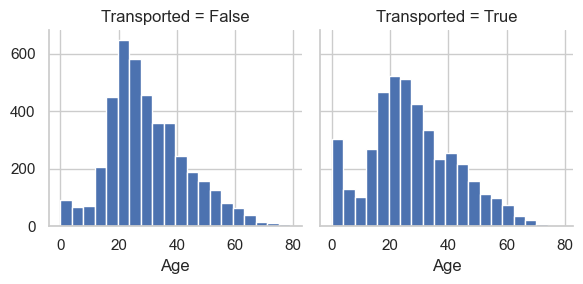

In [876]:
g = sns.FacetGrid(train_df, col='Transported')
g.map(plt.hist, 'Age', bins=20)

<h3>Observations</h3>

<ul>
<li>Age does not seem to have a significant impact on being transported, as the distribution of the histograms are similar to the age distribution.</li>
<li>A high proportion of infants were transported, indicating the need for further analysis to determine the cause.</li>
</ul>

<h3>Decisions</h3>
<ul>
<li>Create age bands with intervals of 10 years.</li>
</ul>

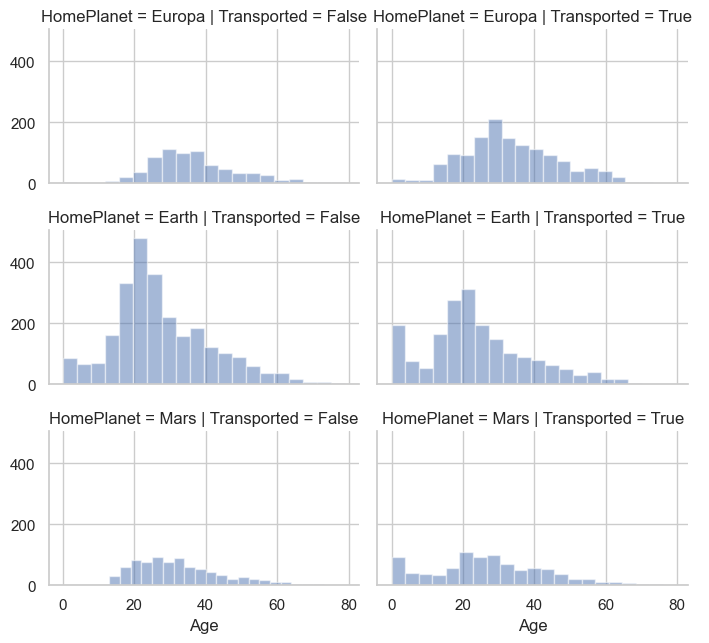

In [877]:
grid = sns.FacetGrid(train_df, col='Transported', row='HomePlanet', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

<h3>Observations</h3>

<ul>
<li>We once again observe that infants comparative to other age groups, have a high likelihood of being transorted, and particularly infants on Earth.</li>
<li>Earth, which had the highest number of passengers, has a relatively low proportion of transported passengers compared to other planets.</li>
</ul>

<h3>Decisions</h3>
<ul>
<li>HomePlanet should definitively be included in our model, validating earlier assumptions</li>
<li>Complete HomePlanet</li>
</ul>

Next, we will work on correlating categorical features to our target to further explore our data.

c:\Users\BupeChindongo\OneDrive\2024\Upskilling\Projects\Kaggle competitions\Spaceship titanic\venv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\BupeChindongo\OneDrive\2024\Upskilling\Projects\Kaggle competitions\Spaceship titanic\venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


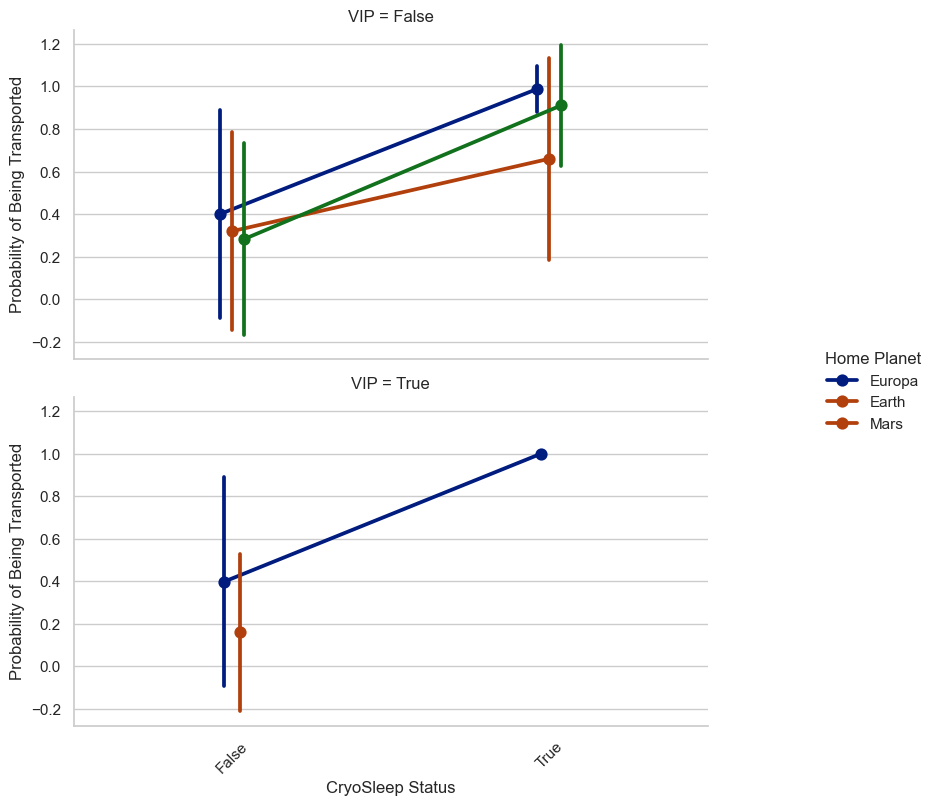

In [878]:
sns.set_theme(style="whitegrid")


grid = sns.FacetGrid(train_df, row='VIP', height=4, aspect=2)
grid.map(sns.pointplot, 'CryoSleep', 'Transported', 'HomePlanet', 
         palette='dark', errorbar='sd', dodge=True)

grid.add_legend(title='Home Planet', bbox_to_anchor=(1.05, 0.5), loc='center right')
grid.set_axis_labels('CryoSleep Status', 'Probability of Being Transported')
plt.xticks(rotation=45)
plt.subplots_adjust(right=0.8)
plt.show()

<h3>Observations</h3>

<ul>
<li>There is a significant correlation between being transported and being a VIP.</li>
<li>VIPs who were in CryoSleep were not transported for Earth and Mars.</li>
<li>Those who were not VIPs and were in cryosleep had a significantly high probability of being transported. </li>
</ul>


<h3>Decisions</h3>
<ul>
<li>Complete CryoSleep and VIP features as they will be important to our model, Validating assumption 1.</li>
</ul>

<h3>Wrangle Data</h3>

We will now begin the data wrangling process in order to action our decisions based on our assumptions. We will achieve this by creating, modifying, and completing features in our dataset.

<h3>Drop features</h3>

As it is the fastest task, and will allow us to deal with fewer data points, we will begin by dropping the 'PassengerId' and 'Name' features.

In [879]:


train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

<h3>Completing features</h3>

Following the dropping of features, we will complete all incomplete features outside of features related to recreational spend. This is necessary to get accurate results in the proceeding feature engineering.

We will begin with Age, as Age has a high likelihood of being strongly correlated to being transported. 

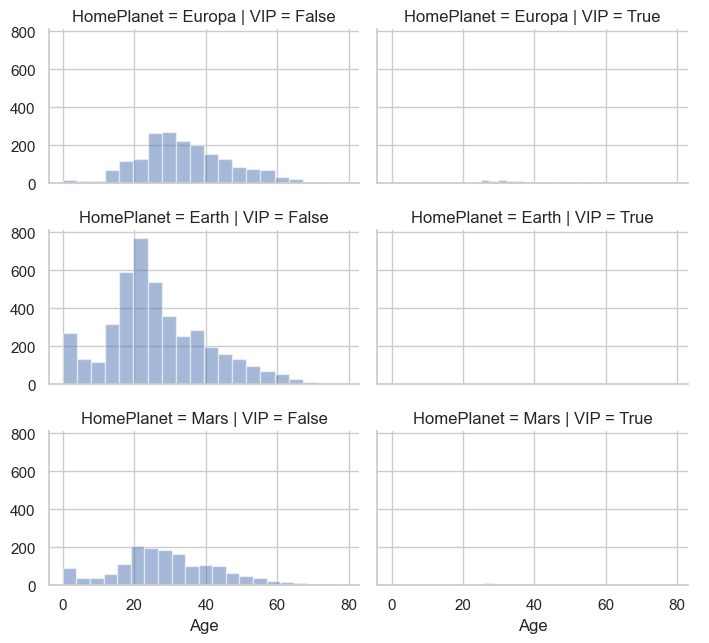

In [880]:
grid = sns.FacetGrid(train_df, col='VIP', row='HomePlanet', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Age, as shown above, has a correlation with ones HomePlanet, as well as VIP status. based on this, we will impute the null age values based on the mode accross these two values. However, in order to impute Age accross HomePlanet and VIP, we need these two features to also be complete. Given the complexity that trying to impute these features based on other related features which may also contain nulls, we will impute these solely on their mode, as in these cases, the mode is the overwhelming majority of the features.

In [881]:
train_df['HomePlanet'] = train_df['HomePlanet'].fillna(train_df['HomePlanet'].mode()[0])
train_df['VIP'] = train_df['VIP'].fillna(train_df['VIP'].mode()[0])

test_df['HomePlanet'] = test_df['HomePlanet'].fillna(test_df['HomePlanet'].mode()[0])
test_df['VIP'] = test_df['VIP'].fillna(test_df['VIP'].mode()[0])

C:\Users\BupeChindongo\AppData\Local\Temp\ipykernel_13712\280637892.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['VIP'] = train_df['VIP'].fillna(train_df['VIP'].mode()[0])
C:\Users\BupeChindongo\AppData\Local\Temp\ipykernel_13712\280637892.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['VIP'] = test_df['VIP'].fillna(test_df['VIP'].mode()[0])


Now that we have completed these features, we may continue with the imputation of Age.

In [882]:
import pandas as pd


mode_ages = train_df.groupby(['HomePlanet', 'VIP'])['Age'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.dropna().median())

def impute_age_based_on_homeplanet_and_vip(df):
    mode_ages = df.groupby(['HomePlanet', 'VIP'])['Age'].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else x.dropna().median()
    )
    
    
    def impute_age(row):
        if pd.isnull(row['Age']):
            return mode_ages[(row['HomePlanet'], row['VIP'])]
        else:
            return row['Age']
    
    df['Age'] = df.apply(impute_age, axis=1)
    return df

train_df = impute_age_based_on_homeplanet_and_vip(train_df)
test_df = impute_age_based_on_homeplanet_and_vip(test_df)


Next, we will impute cryosleep based on a passenger's VIP status. This is because it does not make sense financially to be a VIP and be in cryosleep, as it would under most cases be mismanagement of funds. We will first tabulate these features to confirm this assumption, and then proceed with this imputatin should the assumption be proven true.

In [883]:
crosstab_cryosleep_vip = pd.crosstab(train_df['VIP'], train_df['CryoSleep'])
print(crosstab_cryosleep_vip)

CryoSleep  False  True 
VIP                    
False       5264   3016
True         175     21


In [884]:


def impute_cryosleep_based_on_vip(df):
    
    cryosleep_mode_by_vip = df.groupby('VIP')['CryoSleep'].agg(lambda x: x.mode()[0] if not x.mode().empty else x.dropna().mode()[0])
    
    
    def impute_cryosleep(row):
        if pd.isnull(row['CryoSleep']):
            return cryosleep_mode_by_vip[row['VIP']]
        else:
            return row['CryoSleep']
    
    
    df['CryoSleep'] = df.apply(impute_cryosleep, axis=1)
    return df


train_df = impute_cryosleep_based_on_vip(train_df)
test_df = impute_cryosleep_based_on_vip(test_df)


Finally, we will complete Destination based on a passenger's HomePlanet. We will leave cabin incomplete until feature engineering, as the state which it is currently in makes it very difficult to make any meaningful imputations.

In [885]:
import pandas as pd

def impute_destination_based_on_homeplanet(df):
    
    mode_destination = df.groupby('HomePlanet')['Destination'].agg(
        lambda x: x.mode()[0] if not x.mode().empty else x.dropna().mode()[0] if not x.dropna().empty else "Default"
    )
    
    
    def impute_destination(row):
        if pd.isnull(row['Destination']):
            return mode_destination[row['HomePlanet']]
        else:
            return row['Destination']
    
    
    df['Destination'] = df.apply(impute_destination, axis=1)
    return df


train_df = impute_destination_based_on_homeplanet(train_df)
test_df = impute_destination_based_on_homeplanet(test_df)


<h3>Feature Engineering</h3>

Next, we will engineer new features based on existing features, and change existing features to best fit the models which we will be building. 

The following changes will be made: 
<ul>
<li>Age to be banded</li>
<li>Cabin to be separated and one hot encoded</li>
<li>Create new feature for highest recreational spend</li>
<li>Band recreational spends</li>
</ul>

We begin by banding age.

In [886]:
bins = [0, 5, 12, 19, 35, 60, float('inf')] 
labels = ['Young Children', 'Children', 'Teenagers', 'Young Adults', 'Adults', 'Seniors']

train_df['AgeGroup'] = pd.cut(train_df['Age'], bins=bins, labels=labels, right=False)
test_df['AgeGroup'] = pd.cut(test_df['Age'], bins=bins, labels=labels, right=False)



In [887]:
age_group_mapping = {
    'Young Children': 0, 
    'Children': 1,
    'Teenagers': 2,
    'Young Adults': 3,
    'Adults': 4,
    'Seniors': 5  
}

train_df['Age'] = train_df['AgeGroup'].map(age_group_mapping)

train_df = train_df.drop('AgeGroup', axis=1)

test_df['Age'] = test_df['AgeGroup'].map(age_group_mapping)

test_df = test_df.drop('AgeGroup', axis=1)

Cabin Next.

In [888]:
train_df[['Deck', 'Number', 'Side']] = train_df['Cabin'].str.split('/', expand=True)
test_df[['Deck', 'Number', 'Side']] = test_df['Cabin'].str.split('/', expand=True)


train_df['Number'] = pd.to_numeric(train_df['Number'], errors='coerce')
test_df['Number'] = pd.to_numeric(test_df['Number'], errors='coerce')

mode_value = train_df['Number'].mode()
mode_number = mode_value[0]
train_df['Number'] = train_df['Number'].fillna(mode_number)
print(train_df['Number'].isnull().sum())

mode_value = test_df['Number'].mode()
mode_number = mode_value[0]
test_df['Number'] = test_df['Number'].fillna(mode_number)


0


In [889]:
train_df = pd.get_dummies(train_df, columns=['Side'])
test_df = pd.get_dummies(test_df, columns=['Side'])


In [890]:
train_df = train_df.drop('Deck', axis=1)
train_df = train_df.drop('Cabin', axis=1)

test_df = test_df.drop('Deck', axis=1)
test_df = test_df.drop('Cabin', axis=1)

Following this, we will fill in the NaNs in the recreational spend columns, and then create a feature indicating in which of the recreational areas someone had the highest spend.

In [891]:
spend_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_df[spend_columns] = train_df[spend_columns].fillna(0)
test_df[spend_columns] = test_df[spend_columns].fillna(0)

print(train_df[spend_columns].isnull().sum())  


RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


In [892]:
spend_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_df['MaxSpendArea'] = train_df[spend_columns].idxmax(axis=1)

test_df['MaxSpendArea'] = test_df[spend_columns].idxmax(axis=1)


print(train_df[['MaxSpendArea']].head())


  MaxSpendArea
0  RoomService
1          Spa
2          Spa
3          Spa
4          Spa


In [893]:
#One-hot encode Max Spend Area
train_df = pd.get_dummies(train_df, columns=['MaxSpendArea'])
test_df = pd.get_dummies(test_df, columns=['MaxSpendArea'])

Finally, let us change the formats of HomePlanet and Destination so that they can be understood by our models.

In [894]:
train_df = pd.get_dummies(train_df, columns=['HomePlanet', 'Destination'])

test_df = pd.get_dummies(test_df, columns=['HomePlanet', 'Destination'])



<h3>Model</h3>

We are now ready to train models and predict the solution. Given that we are modelling from a supervised learning approach, and we want to idetify a relationship between a target variable and other variables, there are a few models which are ideal for this task. However, due to the number of features that our feature engineering has resulted it, it seems prudent to utilize a neural network for this task.

In [895]:
X_train = train_df.drop("Transported", axis=1)
Y_train = train_df["Transported"]
X_test  = test_df


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])


history = model.fit(X_train_scaled, Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Y_pred = model.predict(X_test_scaled)
Y_pred = (Y_pred > 0.5).astype(int)  

Y_pred_bool = Y_pred.astype(bool)


submission_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': Y_pred_bool.flatten()})
submission_df.to_csv('neural_network_submission.csv', index=False)
print("Neural network predictions saved to 'neural_network_submission.csv'.")

c:\Users\BupeChindongo\OneDrive\2024\Upskilling\Projects\Kaggle competitions\Spaceship titanic\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6616 - loss: 0.5968 - val_accuracy: 0.7637 - val_loss: 0.4885
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7666 - loss: 0.4893 - val_accuracy: 0.7683 - val_loss: 0.4976
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7744 - loss: 0.4630 - val_accuracy: 0.7683 - val_loss: 0.5213
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7790 - loss: 0.4575 - val_accuracy: 0.7700 - val_loss: 0.5132
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7873 - loss: 0.4447 - val_accuracy: 0.7625 - val_loss: 0.5295
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7916 - loss: 0.4356 - val_accuracy: 0.7671 - val_loss: 0.5258
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7870 - loss: 0.4334 - val_accuracy: 0.7602 - val_loss: 0.5665
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7924 - loss: 0.4301 - val_accuracy: 0